In [1]:
#imports
import numpy as np
import splat
import pandas as pd
import glob
from astropy.io import ascii
import matplotlib.pyplot as plt
from tqdm import tqdm
splat.initializeStandards()
import seaborn as sns
import popsims
splat.initializeStandards(all=True)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
%matplotlib inline



Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database


In [2]:
ABS_MAG_FILE='/users/caganze/research/popsims/data/polynomial_relations.pkl'

In [3]:
 KVALS={'2MASS_KS': {\
            'spt': [0.,0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.,5.5,6.,6.5,7.,8.,9.,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20.,21.,22.,23.,24.,25.,26.,27.,28.,29.,30.,31.,32.,33.,34.,34.5,35.,35.5,36.,37.,37.5,38.,39.,39.5,40.5,41.,41.5,42.],\
            'values': [3.81, 3.82, 3.87, 3.9, 4.04, 4.07, 4.16, 4.21, 4.25, 4.26, 4.48, 4.57, 4.66, 4.78, 4.82, 4.98, 5.11, 5.22, 5.36, 5.67, 5.85, 6.06, 6.27, 6.54, 7.19, 7.55, 7.93, 8.36, 9.01, 9.32, 9.47, 9.76, 9.97, 10.11, 10.22, 10.3, 10.45, 10.55, 10.8, 10.9, 11.3, 11.4, 11.82, 12.27, 12.62, 12.7, 12.74, 12.9, 12.87, 13.19, 13.69, 14.51, 14.66, 14.9, 15.18, 15.54, 16.36, 16.85, 17.43, 18.48, 19.32, 21.5, 23, 23.5, 24],\
            'rms': np.zeros(65)+0.05}}

In [4]:
sptgrid=np.arange(10, 41, 100)

In [5]:
def get_colors(sp, flt, filt_2mass):
    #measuring filtermags in for two filters and comparing that to target filters
    mag, mag_unc = splat.filterMag(sp, flt)
    #calculate the mag of the standard in J and H
    mag_2mass, mag_unc2mass = splat.filterMag(sp, filt_2mass)
    #calculate the offset 
    return mag_2mass-mag, (mag_unc**2+ mag_unc2mass**2)**0.5

In [6]:
#load spectra, ignore binaries, objects with high uncertainty in mag and objects without parallaxes
splat_db=splat.searchLibrary(vlm=True, giant=False, young=False, binary=False)
splat_db['SHORTNAME']=splat_db.DESIGNATION.apply(lambda x: splat.designationToShortName)
sml=splat_db[~ ((splat_db.H_2MASS_E > 0.5) | (splat_db.J_2MASS_E > 0.5)) ]

#sds=sml[(sml.METALLICITY_CLASS=='sd') | (sml.METALLICITY_CLASS=='esd')  ]
sml=sml[~((sml.METALLICITY_CLASS=='sd') | (sml.METALLICITY_CLASS=='esd') \
          | (sml.MEDIAN_SNR <20))]

In [7]:
#verified list of sds


In [8]:
#get y dwarfs
def get_shortname(n):
    return splat.designationToShortName(n).replace('J', 'WISE')
schn='/Users/caganze/research/wisps/data/schneider/*.txt'
schntb=pd.read_csv('/Users/caganze/research/wisps/data/schneider2015.txt', 
                   delimiter=' ').drop(columns='Unnamed: 14')
schntb['shortname']=schntb.Name.apply(get_shortname)
spectra_schn=[]
for f in glob.glob(schn):
    d=ascii.read(f).to_pandas()
    shortname=(f.split('/')[-1]).split('.txt')[0]
    s=splat.Spectrum(wave=d.col1, 
                     flux=d.col2,
                     noise=d.col3, 
                     name=shortname)
    #measure snr 
    mask= np.logical_and(d.col1>1.0, d.col1<2.4)
    snr= (np.nanmedian(d.col2[mask]/d.col3[mask]))
    spectra_schn.append([s, snr])

In [9]:
mdwarfs=sml[ (sml.SPEX_TYPE.apply(splat.typeToNum) <20)]
ldwarfs=sml[ (sml.SPEX_TYPE.apply(splat.typeToNum).between(20, 30))]
tdwarfs=sml[ (sml.SPEX_TYPE.apply(splat.typeToNum).between(30, 40))]

In [10]:
#tighter_constraints on m dwarfs 
mdwarfs=mdwarfs[(~mdwarfs.PARALLAX.isna()) & (mdwarfs.MEDIAN_SNR >100)]
ldwarfs=ldwarfs[ (ldwarfs.MEDIAN_SNR >70)]

In [11]:
def choose_ten(df):
    if len(df) >10:
        return df.sort_values('MEDIAN_SNR', ascending=False)[:10]
    else:
        return df

In [12]:
#tdwarfs.MEDIAN_SNR

In [13]:
ls=ldwarfs.groupby('SPEX_TYPE').apply(choose_ten).reset_index(drop=True)#.groupby('SPEX_TYPE').count()

In [14]:
smlf=pd.concat([mdwarfs, ls, tdwarfs]).reset_index(drop=True)

In [15]:
def get_file(x):
    try:
        return splat.getSpectrum(filename=x)[0]
    except:
        return 

In [16]:
%%capture
templs=smlf.DATA_FILE.apply(lambda x: get_file(x))
#sds_spectra=sds.DATA_FILE.apply(lambda x:  get_file(x))


#all_spectra=pd.read_pickle('/users/caganze/research/popsims/data/splat_spectra.pkl')
#sd_spectra=pd.read_pickle('/users/caganze/research/popsims/data/sd_spectra.pkl')

In [17]:
schntb['spectra']=[x[0] for x in  spectra_schn]

schntb['snr']=[x[1] for x in  spectra_schn]

schntb=schntb[schntb.snr>=2.].reset_index(drop=True)

all_spectra=np.concatenate([templs,schntb.spectra.values ])

In [18]:
len(all_spectra)

348

In [19]:
#import pickle
#output = open('/users/caganze/research/popsims/data/splat_spectra.pkl', 'wb')
#pickle.dump(all_spectra, output)
#output.close()

#import pickle
#output = open('/users/caganze/research/popsims/data/sd_spectra.pkl', 'wb')
#pickle.dump(sds_spectra, output)
#output.close()


In [20]:
def make_spt_number(spt):
    ##make a spt a number
    if isinstance(spt, str):
        return splat.typeToNum(spt)
    else:
        return spt

In [21]:
spts=np.concatenate([smlf.SPEX_TYPE.apply(make_spt_number).values,
                     schntb.Spec.apply(make_spt_number).values,
                    ])

In [22]:
assert len(spts) == len(all_spectra)

In [23]:
ascii.write?

In [24]:
#for f in glob.glob('/users/caganze/research/splat/resources/filters/*.dat'):
#    d=ascii.read(f,names=['LAM', 'TRANSMISSION'])
#    d['LAM']=d['LAM']/10_000
    #print (d)
#    ascii.write(d, f.replace('.dat', '.txt'), comment='#')
#    plt.plot(d['LAM'], d['TRANSMISSION'])
#    del d
    

In [25]:
#sds_spts=sds.SPEX_TYPE.apply(make_spt_number).values

In [26]:
#this has already been simulated 
darf_pairs={#[{'WFIRST_WFIJ':  '2MASS J'],
           #['WFIRST_WFIY', 'PANSTARRS_Y'],
           #['WFIRST_WFIZ', 'PANSTARRS_Z'],
           #['WFIRST_WFIH', '2MASS H'],
           #['WFIRST_WFIF', '2MASS H'],
           #['WFIRST_WFIR', 'PANSTARRS_Z'],
           #['EUCLID_J', '2MASS J'],
           #['EUCLID_H', '2MASS H'],
           #['EUCLID_Y','PANSTARRS_Y'],
        'NIRISS_F115W': {'ref': '2MASS J', 'method':'ab'},
        #'NIRISS_F140M': {'ref': '2MASS H', 'method': 'ab'},
        'NIRISS_F150W': {'ref': '2MASS H', 'method': 'ab'},
        'NIRISS_F200W': {'ref': '2MASS H', 'method': 'ab'}}
             #['NIRCAM_F140M', '2MASS H', 'ab'],
             #['NIRCAM_F150W', '2MASS H', 'ab'],
             #['NIRCAM_F200W', '2MASS H', 'ab'],
        
        
           #['WFC3_F110W', '2MASS J', 'ab'],
           #['WFC3_F140W', '2MASS J', 'ab'],
           #['WFC3_F160W', '2MASS H', 'ab'],
           #['VISTA_Z', 'PANSTARRS_Z'],
           #['VISTA_Y', 'PANSTARRS_Y'],
           #['VISTA_J', '2MASS J'],
           #['VISTA_H', '2MASS H'],
           #['VISTA_KS', '2MASS_H'],
           #['UKIDSS_Z', 'PANSTARRS_Z'],
           #['UKIDSS_Y', 'PANSTARRS_Y'],
           #['UKIDSS_J', '2MASS J'],
           #['UKIDSS_H', '2MASS H'],
           #['UKIDSS_K','2MASS_H'],
           #['LSST_G', 'PANSTARRS_I'],
           #['LSST_R', 'PANSTARRS_Z'],
           #['LSST_I',  'PANSTARRS_Z'],
           #['LSST_Z',  'PANSTARRS_Z'],
           #['LSST_Y',  'PANSTARRS_Y'],
           #['SDSS_R',  'PANSTARRS_Z'],
           #['SDSS_I',  'PANSTARRS_Z'],
           #['SDSS_Z',  'PANSTARRS_Z']]


sd_pairs= [['PANSTARRS_Z', 'SDSS_Z'],
           ['PANSTARRS_I', 'SDSS_I'],
           ['PANSTARRS_Y', 'SDSS_Z'],
           ['PANSTARRS_R', 'SDSS_R'],
           #['VISTA_R', 'SDSS_R'],
           ['VISTA_Z', 'SDSS_Z'],
           ['VISTA_Y', 'SDSS_Z'],
           ['VISTA_J', '2MASS J'],
           ['UKIDSS_Z', 'SDSS_Z'],
           ['UKIDSS_Y', 'SDSS_Z'],
           ['UKIDSS_J', '2MASS J'],
           ['UKIDSS_H', '2MASS H'],
           ['UKIDSS_K', '2MASS KS']]


In [27]:
#sd_absolute_mag(spt, 20)

In [28]:
splat.typeToNum

<function splat.utilities.typeToNum(inp, subclass='dwarf', error='', uncertainty=0.0, luminosity_class='', metallicity_class='', age_class='', color_class='', peculiar=False, verbose=False, **kwargs)>

In [29]:
#remove nones
nones= np.array(all_spectra)==None
all_spectra=all_spectra[~nones]
spts=spts[~nones]
assert len(spts) == len(all_spectra)

In [30]:
def compute_colors(sp, sd=False):
    fl_pairs=None
    if sd: fl_pairs=sd_pairs
    if not sd: fl_pairs=darf_pairs
    sp.normalize()
    res={}
    for p in fl_pairs.keys():
        res.update({p+'and'+fl_pairs[p]['ref']: \
                    get_colors(sp, p, fl_pairs[p]['ref'])})
    return res

In [31]:
zhang_subds=pd.read_pickle(popsims.DATA_FOLDER+'/combined_sd_templates.pkl')
zhang_subds['spt']=zhang_subds.sptype.apply(make_spt_number)

In [32]:
optical_stds=pd.read_pickle(popsims.DATA_FOLDER+'/combined_optical_templates.pkl')
optical_stds['spt']=optical_stds.sptype.apply(make_spt_number)

In [33]:
#only pick those ith sds or esd or usd in their sptype
zhang_subds=zhang_subds[np.logical_or.reduce([zhang_subds.sptype.str.startswith('esd'),\
                                             zhang_subds.sptype.str.startswith('sd'),\
                                              zhang_subds.sptype.str.startswith('usd')])]
#add 
optical_sd_bool=np.logical_or.reduce([optical_stds.sptype.str.startswith('esd'),\
                                    optical_stds.sptype.str.startswith('sd'),\
                                    optical_stds.sptype.str.startswith('usd')]).astype(bool)


In [34]:
zhang_subds=zhang_subds.append(optical_stds[optical_sd_bool])

In [35]:
assert len(zhang_subds)==131

In [36]:
#zhang_subds.spt.values

In [37]:
#sd_df

In [38]:
optical_templates=optical_stds[~optical_sd_bool].spectra.values
optical_spts=optical_stds[~optical_sd_bool].spt.values

In [39]:
optical_templates=optical_templates[optical_spts>=10]
optical_spts=optical_spts[optical_spts>=10]

assert len(np.concatenate([optical_templates, all_spectra]))==\
len(np.concatenate([optical_spts, spts]))

In [40]:
#sd_df=pd.DataFrame.from_records([compute_colors(x, sd=True) for x in tqdm(zhang_subds.spectra.values)])
#sd_df['spt']=zhang_subds.spt.values

In [41]:
len(all_spectra)

348

In [42]:
df=pd.DataFrame.from_records([compute_colors(x, sd=False) for x in tqdm(np.concatenate([all_spectra, optical_templates]))])
df['spt']=np.concatenate([spts,  optical_spts])

100%|██████████| 388/388 [01:43<00:00,  3.76it/s]


In [43]:
#sd_df

In [44]:
#ghj

In [45]:
def k_clip_fit(x, y, sigma_y, sigma = 5, n=6):
    
    '''Fit a polynomial to y vs. x, and k-sigma clip until convergence
    hard-coded, returns mask array
    '''
    
    not_clipped = np.ones_like(y).astype(bool)
    n_remove = 1
    
    #use median sigma
    #median_sigma= np.nanmedian(sigma_y)
    
    while n_remove > 0:

        best_fit = np.poly1d(np.polyfit(x[not_clipped], y[not_clipped], n))
        
        norm_res = (np.abs(y - best_fit(x)))/(sigma_y)
        remove = np.logical_and(norm_res >= sigma, not_clipped == 1)
        n_remove = sum(remove)
        not_clipped[remove] = 0   
        
    return  not_clipped

def fit_with_nsigma_clipping(x, y, y_unc, n, sigma=3.):
    not_clipped = k_clip_fit(x, y, y_unc, sigma = sigma)
    return not_clipped, np.poly1d(np.polyfit(x[not_clipped], y[not_clipped], n))

In [46]:
rocio_coeffs={'SDSS_R':[-0.03, 1.3 , 7.2 , 0.62],\
              'SDSS_I':[-0.009, 0.9, 6.8, 0.55],\
              'SDSS_Z':[-0.005, 0.74, 6.7 ,  0.5]}

In [47]:
rocio_relations={}

In [48]:
rocio_coeffs['SDSS_R'][:-1]

[-0.03, 1.3, 7.2]

In [49]:
for k in rocio_coeffs.keys():
    s={k: {'x': 'spt', 'y': k, 'fit':np.poly1d(rocio_coeffs[k][:-1]), \
                'scatter': rocio_coeffs[k][-1], \
                'method': 'polynomial',\
                'range': [10, 24] ,
          'x0': 10}}
    rocio_relations.update(s)
    pass

In [50]:
rocio_relations['SDSS_R']['fit'](np.arange(16, 24)-10)

array([13.92, 14.83, 15.68, 16.47, 17.2 , 17.87, 18.48, 19.03])

In [51]:
#

In [52]:
#absolute magnitude relation
import splat.empirical as spe

kirkpa2019pol={'2MASS H':{'pol':np.poly1d(np.flip([36.9714, -8.66856, 1.05122 ,-0.0344809])), 
                    'scatter':.67, 'range':[36, 44]}}
kirkpa2020pol={'2MASS H':{'pol':np.poly1d(np.flip([-6.918e01, 1.1863e+01,-5.4084e-1, 8.466e-03 ])), 
                    'scatter':.51, 'range':[36, 44]}}
best_dict={'2MASS J': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39], \
            'values': [10.36,10.77,11.15,11.46,11.76,12.03,12.32,12.77,13.51,13.69,14.18,14.94,14.90,14.46,14.56,15.25,14.54,14.26,13.89,14.94,15.53,16.78,17.18,17.75],\
            'rms': [0.30,0.30,0.42,0.34,0.18,0.15,0.21,0.24,0.28,0.25,0.60,0.20,0.13,0.71,0.5,0.12,0.06,0.16,0.36,0.12,0.27,0.76,0.51,0.5]},
        '2MASS H': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39], \
            'values': [9.76,10.14,10.47,10.74,11.00,11.23,11.41,11.82,12.45,12.63,13.19,13.82,13.77,13.39,13.62,14.39,13.73,13.67,13.57,14.76,15.48,16.70,17.09,17.51],\
            'rms': [0.30,0.31,0.43,0.35,0.23,0.21,0.25,0.29,0.3,0.30,0.62,0.31,0.20,0.73,0.5,0.18,0.15,0.24,0.40,0.24,0.37,0.78,0.5,0.5]},
       
        'PANSTARRS_R': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,28], \
            'values': [15.37,16.76,17.74,18.14,18.37,18.74,19.02,19.61,20.60,20.74,21.21,22.88],\
            'rms': [0.43,0.50,0.51,0.37,0.31,0.28,0.29,0.39,0.56,0.37,0.78,0.5]},
        'PANSTARRS_I': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,35], \
            'values': [13.25,14.18,15.00,15.62,16.00,16.41,16.73,17.40,18.35,18.71,19.27,20.09,20.38,20.09,20.22,21.10,21.97,22.69],\
            'rms': [0.34,0.39,0.48,0.39,0.26,0.25,0.26,0.34,0.38,0.33,0.65,0.36,0.79,0.5,1.14,0.5,0.5,0.5]},
        'PANSTARRS_Z': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39], \
            'values': [12.27,12.98,13.61,14.17,14.52,14.93,15.30,15.88,16.68,16.94,17.35,18.18,18.10,17.69,17.98,18.84,18.26,18.08,18.02,19.20,19.82,21.17,21.52,21.82],\
            'rms': [0.32,0.34,0.45,0.37,0.25,0.23,0.24,0.21,0.33,0.29,0.62,0.26,0.22,0.73,0.5,0.21,0.23,0.25,0.39,0.22,0.32,0.78,0.52,0.5]},
        'PANSTARRS_Y': {\
            'spt': [16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39], \
            'values': [11.76,12.31,12.81,13.23,13.58,13.97,14.33,14.89,15.66,15.87,16.27,17.13,17.04,16.57,16.77,17.45,16.75,16.50,16.32,17.43,18.06,19.34,19.75,20.37],\
            'rms': [0.30,0.31,0.43,0.36,0.23,0.21,0.24,0.29,0.32,0.28,0.61,0.25,0.21,0.72,0.5,0.16,0.13,0.22,0.38,0.18,0.32,0.81,0.59,0.5]}}

BEST={}
BEST['rms']={}
BEST['range']={}
for k in best_dict.keys():
    BEST[k]=fit_with_nsigma_clipping(np.array(best_dict[k]['spt']), 
                                      np.array(best_dict[k]['values']), 
                                      np.array(best_dict[k]['rms'])
                                     , 6, sigma=5.)
    BEST['rms'][k]=np.nanmedian(best_dict[k]['rms'])
    BEST['range'][k]=[np.nanmin(best_dict[k]['spt']), np.nanmax(best_dict[k]['spt'])]
    
    
from astropy.io import ascii
def make_mamajek_fit(spt):
    mamjk=ascii.read('/users/caganze/research/wisps/data/mamajek_relations.txt').to_pandas().replace('None', np.nan)
    js=mamjk.M_J.apply(float).values
    jminush=mamjk['J-H'].apply(float).values
    hs=js-jminush
    
    spts=mamjk.SpT.apply(splat.typeToNum).apply(float).values
    
    hsortedindex=np.argsort(hs)
    jsortedindex=np.argsort(js)
    
    hval=np.interp(spt,  spts[hsortedindex], hs[hsortedindex])
    jval=np.interp(spt,  spts[jsortedindex], js[jsortedindex])
    
    return ((jval, 0.4), (hval, 0.4))

def absolute_mag_kirkpatrick(spt, filt):
    if filt != '2MASS H':
        return np.nan
    else:
        pol=kirkpa2019pol[filt]['pol']
        unc=kirkpa2019pol[filt]['scatter']
        return pol(spt-30), unc

def get_subdwarf_abs_mag(spt, flter):
    m, munc=np.nan, np.nan
    #replace panstarrs by sdss
    m, munc=spe.typeToMag(spt, flter, reference='zhang2013')
        
    return m, munc
        
def get_abs_mag(spt, flter, method='vega'):
    #base absolute mag relations to use to convert from other absmag
    m, munc=(np.nan, np.nan)
    
    if ((flter.upper()=='2MASS J') or (flter.upper()=='2MASS_J')):
        corr=splat.photometry.vegaToAB('2MASS J')
        ((m, munc), (h, hunc))=make_mamajek_fit(spt)
        if method == 'ab': m+corr
        
    if ((flter.upper()=='2MASS H') or (flter.upper()=='2MASS_H')):
        corr=splat.photometry.vegaToAB('2MASS H')
        if spt <36:
            
            #m=BEST['2MASS H'][1](spt)
            #munc= np.nanmedian(best_dict[k]['rms'])
            #m, munc=spe.typeToMag(spt, '2MASS H')
            ((j, junc), (m, munc))=make_mamajek_fit(spt)
            if method == 'ab': m+corr

        else:
            m, munc=absolute_mag_kirkpatrick(spt, '2MASS H')
            if method == 'ab': m+corr
        

    if ((flter.upper()=='2MASS KS') or (flter.upper()=='2MASS_KS')):
        corr=splat.photometry.vegaToAB('2MASS Ks')
        #m, munc= spe.typeToMag(spt, '2MASS J')
        m, munc=spe.typeToMag(spt, '2MASS Ks', ref='dupuy2012')
        if method == 'ab': m+corr
        
    if flter.upper().startswith('PANSTARRS'):
        if np.logical_or(spt> BEST['range'][flter][-1], spt< BEST['range'][flter][0]):
            pass
        else:
            corr=splat.photometry.vegaToAB(flter.upper())
            m=(BEST[k][1])(spt)#+corr
            munc=np.nanmedian(best_dict[k]['rms'])
            if method == 'ab': m+corr
    return m, munc

In [53]:
#import popsims
#popsims.get_distance(get_abs_mag(25, '2MASS J')[0], 28.)

In [54]:
sp_grid=np.arange(15, 42)

In [55]:
BEST['range']['PANSTARRS_R'][-1]

28

In [56]:
#get_abs_mag(25, 'PANSTARRS_Z'), get_subdwarf_abs_mag(25, 'SDSS_Z')

In [57]:
def get_abs_mags(row):
    res={}
    fl_pairs=darf_pairs
    for p in fl_pairs.keys():

        cl=p+'and'+fl_pairs[p]['ref']
        v, ve=get_abs_mag(row.spt, fl_pairs[p]['ref'], method= fl_pairs[p]['method'])
        absm= row[cl][0]+v
        res.update({p: [absm,  (row[cl][1]**2+ve**2)**0.5]})
    return pd.Series(res)

def get_abs_mags_sd(row):
    res={}
    fl_pairs=sd_pairs
    for p in fl_pairs:

        cl=p[0]+'and'+p[1]
        v, ve=get_subdwarf_abs_mag(row.spt, p[1])
        absm= row[cl][0]+v
        res.update({p[0]: [absm,  (row[cl][1]**2+ve**2)**0.5]})
    return pd.Series(res)

#def get_abs_mags_lsst_fromcolor(row):
#    res={}
#    for p in fl_pairs:

#        cl=p[0]+'and'+p[1]
#        v, ve=absolute_sdss(row.spt)[p[1]]
#        absm= row[cl][0]+v
#        res.update({p[0]: [absm,  (row[cl][1]**2+ve**2)**0.5]})
  #  return pd.Series(res)

#def get_abs_mags_lsst_fromcolor_sds(row):
#    res={}
#    for p in fl_pairs:

 #       cl=p[0]+'and'+p[1]
 #       v, ve=sd_absolute_mag(row.spt)[p[1]]
 #       absm= row[cl][0]+v
 #       res.update({p[0]: [absm,  (row[cl][1]**2+ve**2)**0.5]})
 #   return pd.Series(res)
        
    

In [58]:
get_subdwarf_abs_mag(20, '2MASS_J')

(11.9494, 0.52)

In [59]:
#df

In [60]:
tqdm.pandas()
abs_df=df.progress_apply(get_abs_mags, axis=1)
#abs_df=df.progress_apply(get_abs_mags_lsst_fromcolor, axis=1)
#sd_abs_df=sd_df_total.progress_apply(get_abs_mags_lsst_fromcolor_sds, axis=1)


100%|██████████| 388/388 [01:06<00:00,  5.87it/s]


In [61]:
#sd_abs_df=sd_df.progress_apply(get_abs_mags_sd, axis=1)
#abs_df

In [62]:
#sd_abs_df

In [63]:
FITS=pd.read_pickle('/users/caganze/research/popsims/data/polynomial_relations.pkl')

In [64]:
#FITS['absmags']['dwarfs']={}
#FITS['absmags']['subdwarfs']={}
#FITS['colors']['dwarfs']={}
#FITS['colors']['subdwarfs']={}

In [65]:
#for k in BEST['rms'].keys():
#    s={k: {'x': 'spt','y': k, 'fit':BEST[k][-1], 'scatter': BEST['rms'][k], \
#           'method': 'polynomial','range':  BEST['range'][k], 'x0':0}}
#   FITS['absmags']['dwarfs'].update(s)


In [66]:
#len(darf_pairs), len(abs_df.columns)

In [67]:
#FITS

In [68]:
#FITS['references']={'kiman2019': rocio_relations }
#adda zhang realtions
#FITS['references']

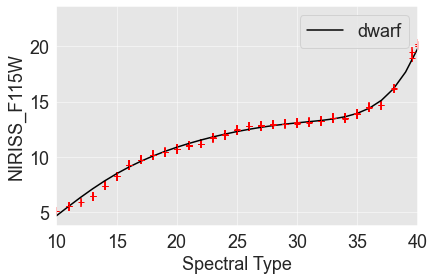

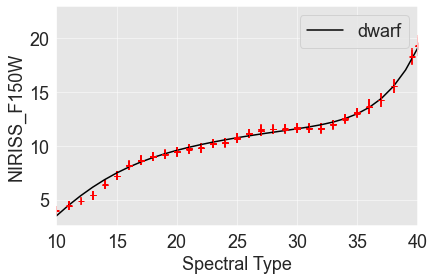

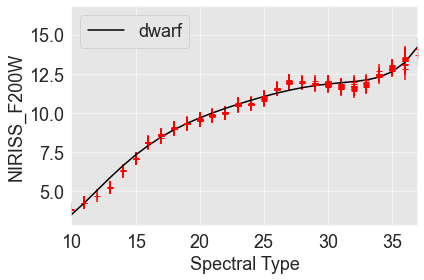

In [88]:
for c in abs_df.columns:
    if c=='spt':
        pass
    else:
        fig, a=plt.subplots()
        vals=np.vstack(abs_df[c].values)
        #vals=np.vstack(sd_abs_df[c].values)
        spts=df.spt.values
        #spts=sd_df.spt.values
        
        #masks
        mask= np.logical_or.reduce([np.isnan(spts), 
                                    np.isnan(vals[:,0]),
                                    np.isnan(vals[:,1])])

        m, fit= fit_with_nsigma_clipping(spts[~mask], 
                                      vals[:,0][~mask], 
                                      vals[:,1][~mask], 6, sigma=3.)
        FITS['absmags']['dwarfs'].update({c: {'x': 'spt',
                                              'y': c,
                                              'fit':fit, \
                                              'scatter': np.nanmedian(vals[:,1]), \
                                              'method': 'polynomial',\
                                              'range':  (np.nanmin(spts[~mask]),\
                                                         np.nanmax(spts[~mask])), \
                                             'x0':0}})
        
        
        spgrid=np.arange(np.nanmin(spts[~mask]), np.nanmax(spts[~mask]))
        a.plot(spgrid, fit(spgrid), c='k', label='dwarf')
        
        
        
        a.errorbar(spts, vals[:,0], fmt='+', 
                   yerr=vals[:,1], color='r')
       
       
       
        a.set_ylabel(c)
        a.set_xlabel('Spectral Type')
        a.legend()
        plt.tight_layout()
        a.set_xlim([np.nanmin(spgrid), np.nanmax(spgrid)])
        #a.set_ylim([fit(np.nanmin(spgrid)), fit(np.nanmax(spgrid))])
        plt.savefig(popsims.FIGURES+'/abs_mag_relations{}.pdf'.format(c))


In [70]:
#FITS

In [71]:
#abs_df.keys()

In [72]:
#def fit_nsigma():
#    return 

In [73]:
#POLYNOMIALS=FITS

In [74]:
#ir=np.vstack(abs_df.LSST_I)[:,0]-np.vstack(abs_df.LSST_R)[:,0]

In [75]:
#h=plt.hist(ir)

In [76]:
#e(spts_m, d=np.ones_like(spts_m)*1000, keys=['LSST_Z', 'LSST_R'], object_type='dwarfs')

In [77]:
#updating WISE
#wise_dict=splat.SPT_ABSMAG_RELATIONS['best2018']['filters']['WISE_W1']
#_, fit_2massk=fit_with_nsigma_clipping(np.array(KVALS['2MASS_KS']['spt']), 
#                                      np.array( KVALS['2MASS_KS']['values']), 
#                                      np.array( KVALS['2MASS_KS']['rms'])
#                                     , 6, sigma=5.)
#add wise relations

#_, fit_wise1=fit_with_nsigma_clipping(np.array(wise_dict['spt']), 
#                                      np.array( wise_dict['values']), 
#                                      np.array( wise_dict['rms'])
#                                     , 6, sigma=5.)
#            'spt': [0.,0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.,5.5,6.,6.5,7.,8.,9.,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20.,21.,22.,23.,24.,25.,26.,27.,28.,29.,30.,31.,32.,33.,34.,34.5,35.,35.5,36.,37.,37.5,38.,39.,39.5,40.5,41.,41.5,42.],\
#            'values': [3.81, 3.82, 3.87, 3.9, 4.04, 4.07, 4.16, 4.21, 4.25, 4.26, 4.48, 4.57, 4.66, 4.78, 4.82, 4.98, 5.11, 5.22, 5.36, 5.67, 5.85, 6.06, 6.27, 6.54, 7.19, 7.55, 7.93, 8.36, 9.01, 9.32, 9.47, 9.76, 9.97, 10.11, 10.22, 10.3, 10.45, 10.55, 10.8, 10.9, 11.3, 11.4, 11.82, 12.27, 12.62, 12.7, 12.74, 12.9, 12.87, 13.19, 13.69, 14.51, 14.66, 14.9, 15.18, 15.54, 16.36, 16.85, 17.43, 18.48, 19.32, 21.5, 23, 23.5, 24],\
#            'rms': np.zeros(65)+0.05}})

In [78]:
#df.spt.values.min()

In [79]:
#get_kirkpatrick_wise(30-10)

In [80]:
#spts_grids=np.linspace(17, 44, 1000)
#w1s=np.array([get_kirkpatrick_wise(x) for x in spts_grids])

In [81]:
#_, fit_wise=fit_with_nsigma_clipping(np.array(spts_grids), 
#                                      np.array(w1s), 
#                                      np.ones(len(w1s))*0.63
#                                     , 6, sigma=5.)
#plt.plot(spts_grids, w1s)
#plt.plot(spts_grids,fit_wise(spts_grids) )


In [82]:
#vals=np.vstack(abs_df['WFC3_F160W'].values)
#spts=df.spt.values
#plt.plot(spts, vals[:,0], 'o')

In [83]:
#FITS['2MASS_K']=(fit_2massk, np.nanmedian(np.array( KVALS['2MASS_KS']['rms'])))
#FITS['WISE_W1']=(fit_wise, 0.63)

In [84]:
#FITS['absmags']['subdwarfs']={}

In [85]:
import pickle
output = open(ABS_MAG_FILE, 'wb')
pickle.dump(FITS, output)
output.close()

In [86]:
#FITS

In [87]:
#FITS['references']['kiman2019']